# Load package

In [1]:
import os, glob, pandas as pd, json, numpy as np, tifffile, cv2
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
from PIL import Image

from utils.eval_utils import (
    polygonann2objdetect,
    coordinates_to_masks,
    get_oid_dict_gt,
    make_gt_dict_from_dataframe,
    subm_to_pred_df,
    get_oid_dict_pred,
    non_max_suppression_mask,
    iou_matrix_mask
)

2023-09-29 12:36:56.687126: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-29 12:36:56.723651: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-29 12:36:58.829040: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Load Ground Truth data
Description: Make ground truth data in dictionary format

In [2]:
# Load directory configurations
data_dir = './data'
data_dir_eval = os.path.join(data_dir, 'k3_datasets')
submission_dir = os.path.join(data_dir_eval, 'kaggle-3-competition-dataset', 'winning_teams_final_submissions')
data_dir_kaggle = os.path.join(data_dir, 'kaggle')
submission_dir = os.path.join(data_dir_eval, 'kaggle-3-competition-dataset/winning_teams_final_submissions/')

# Load GT dataframe
df_solution = pd.read_csv(os.path.join(data_dir_eval, 'kaggle-3-competition-dataset', 'host_solution_file.csv'))
# convert to valid format
df_gt_obj = make_gt_dict_from_dataframe(df_solution)
# convert to dictionary format
gt_dicts = get_oid_dict_gt(df_gt_obj)
print('GT dictionary created')

GT dictionary created


# Load prediction data

In [3]:
team_idx = 2
# Load submission file
list_files_submission = glob.glob(os.path.join(submission_dir, '*.csv'))
file_submission = list_files_submission[team_idx]
# Load submission dataframe
df_submission = pd.read_csv(file_submission)
list_valid_ids = sorted(df_solution['id'].values)
df_submission = df_submission.loc[df_submission['id'].apply(lambda x: x in list_valid_ids)]
# convert submission to prediction dataframe
df_pred = subm_to_pred_df(df_submission)
# convert prediction dataframe to dictionary format
pred_dicts = get_oid_dict_pred(df_pred)

In [4]:
df_hash = pd.read_csv(os.path.join(data_dir_eval, 'kaggle-3-competition-dataset', 'hashed_ids_k3_from_ryan.csv'), header = None)
df_hash.columns = ['case_id', 'hash_id']
# Make lookup table
hash_id_lookup = {
    row['case_id']: row['hash_id']
    for row_idx, row in df_hash.iterrows()
}

In [5]:
file_lookup = {
    hash_id_lookup[os.path.basename(f).split('.tif')[0]]: f
    for f in glob.glob(os.path.join(data_dir, 'k3_datasets/kaggle-3-competition-dataset', '*', '*', 'Tiles', '*.tif'))
    if hash_id_lookup.get(os.path.basename(f).split('.tif')[0])
}

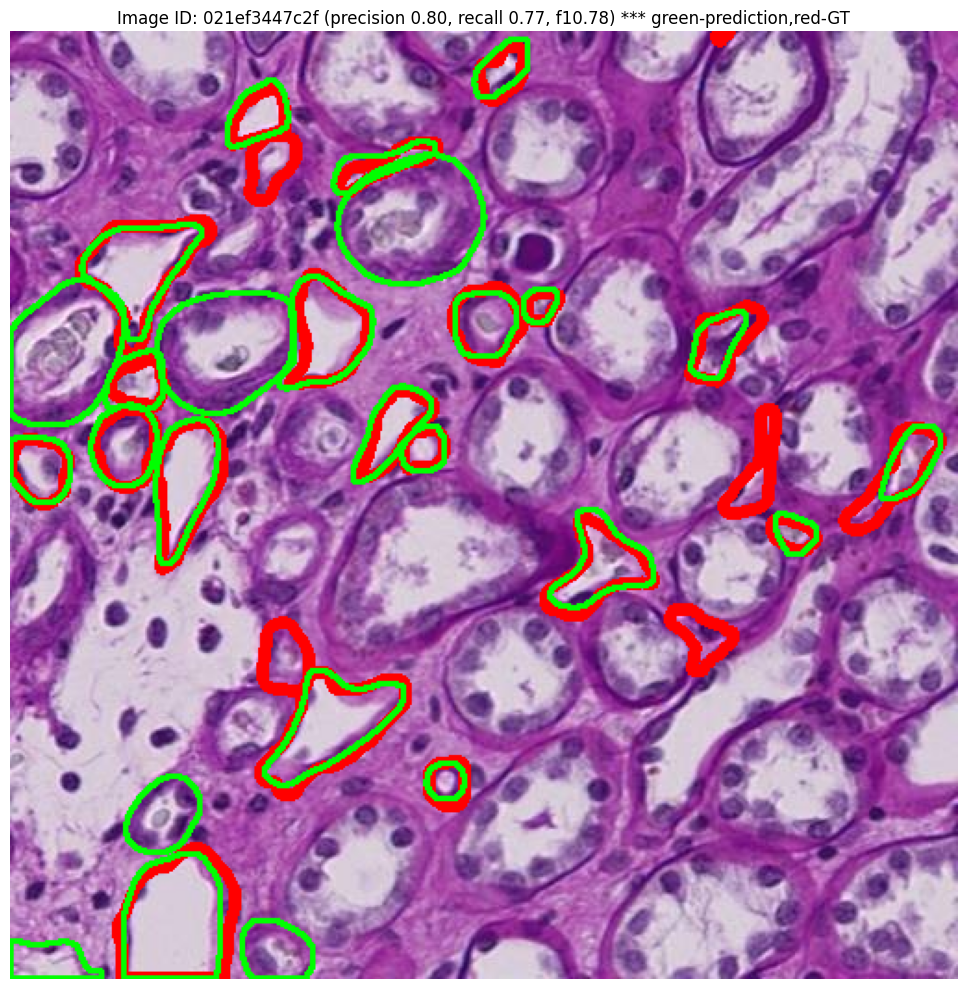

In [6]:
# sample index
idx = 4

# thresholds for inference
iou_threshold_inference = 0.1 # IoU threshold for inference - there is almost no overlaps, meaning small value for this wouldn't affect the predictions
confidence_threshold = 0.5 # confidence score
iou_threshold_metrics = 0.6 # IoU threshold for evaluation

# get attributes (image, masks, scores)
list_image_id = sorted(pred_dicts.keys())
sample_id = list_image_id[idx]
image = tifffile.imread(file_lookup[sample_id])
gt_masks = gt_dicts[sample_id]['groundtruth_instance_masks']
detection_masks = pred_dicts[sample_id]['detection_masks']
detection_scores = pred_dicts[sample_id]['detection_scores']
# cut off predictions by confidence
pred_masks = detection_masks[detection_scores >= confidence_threshold]
pred_scores = detection_scores[detection_scores >= confidence_threshold]
# cut off predictions by IoU
keep = non_max_suppression_mask(pred_masks, pred_scores, iou_threshold_inference)
pred_masks = pred_masks[keep]
pred_scores = pred_scores[keep]
# calculate confusion matrix - (1) iou matrix (2) matching algorithm (3) calculate confusion matrix
iou_matrix = iou_matrix_mask(gt_masks, pred_masks)
n_min = min(iou_matrix.shape[0], iou_matrix.shape[1])
costs = -(iou_matrix >= iou_threshold_metrics).astype(float) - iou_matrix / (2*n_min)
true_ind, pred_ind = linear_sum_assignment(costs)
match_ok = iou_matrix[true_ind, pred_ind] >= iou_threshold_metrics
# get confusion matrix
tp = match_ok.sum()
fp = (match_ok==False).sum()
fn = pred_masks.shape[0] - tp
# fn # this is not applicable
# get evaluation metrics
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1 = (2 * tp) / (2 * tp + fp + fn)

for idx_gt in range(len(gt_masks)):
    t = gt_masks[idx_gt]
    coord_gt = cv2.findContours(t,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0][0][:,0]
    cv2.drawContours(image, [coord_gt], -1, [255,0,0],5)

for idx_pred in range(len(pred_masks)):
    p = pred_masks[idx_pred]
    coord_pred = cv2.findContours(p,cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)[0][0][:,0]
    cv2.drawContours(image, [coord_pred], -1, [0,255,0],2)
image_pil = Image.fromarray(image)
plt.figure(figsize = (10,10))
plt.imshow(image_pil)
plt.title(f'Image ID: {sample_id} (precision {precision:.2f}, recall {recall:.2f}, f1{f1:.2f}) *** green-prediction,red-GT')
plt.axis('off')
plt.tight_layout()
plt.show()